In [2]:
import pandas as pd

# Reading csv files
responsories_all = pd.read_csv('all-ci-responsories.csv', usecols=['id', 'cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('all-ci-antiphons.csv', usecols=['id', 'cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('source.csv', usecols=['id', 'title', 'rism', 'provenance_id', 'century', 'drupal_path'])
feasts = pd.read_csv('feast.csv', usecols=['id', 'name'])
geo_data = pd.read_csv('geography_data.csv', usecols=['provenance_id', 'provenance','latitude', 'longitude'])

# Add sources to data 
respo_with_sources = pd.merge(responsories_all, sources, how='inner', left_on='source_id', right_on='drupal_path')
antipho_with_sources = pd.merge(antiphons_all, sources, how='inner', left_on='source_id', right_on='id')

# Merge responsories and antiphons
data = pd.concat([respo_with_sources, antipho_with_sources])

In [3]:
# Filter sources to avoid working with fragments etc
freq_of_sources = data['drupal_path'].value_counts()
bigger_sources = freq_of_sources.drop(freq_of_sources[freq_of_sources.values < 100].index).index.tolist()
sources_f = sources[sources['drupal_path'].isin(bigger_sources)]

In [4]:
# Filter feasts from filtered sources
freq_of_feasts = data['feast_id'].value_counts()
print("number of all feasts in bigger sources:", len(freq_of_feasts))
bigger_feasts = freq_of_feasts.drop(freq_of_feasts[freq_of_feasts.values < 10].index).index.tolist()
print("number of all bigger feasts in bigger sources:", len(bigger_sources))
feasts_f = feasts[feasts['id'].isin(bigger_feasts)]

number of all feasts in bigger sources: 911
number of all bigger feasts in bigger sources: 131


In [5]:
# Get data without small sources and feasts
data_f = data[data['drupal_path'].isin(sources_f['drupal_path'])]
data_f = data_f[data_f['feast_id'].isin(feasts_f['id'])]

In [6]:
# Get sources with geographical info
geo_source = pd.merge(sources_f, geo_data, how='inner', left_on='provenance_id', right_on='provenance_id')

In [7]:
# Dicts for feast and source ids
from collections import OrderedDict
source_dict = OrderedDict()
i = 0
for id in sources_f['drupal_path']:
    source_dict[id] = i
    i += 1

feast_dict = OrderedDict()
j = 0
for id in feasts_f['id']:
    feast_dict[id] = j
    j += 1

num_to_feast = OrderedDict()
for k in range(len(feasts_f)):
    num_to_feast[k] = feasts_f['id'].iloc[k]

In [8]:
# Functions translating feast_ids to indexis
def translate_feast(feast_id):
    return feast_dict[feast_id] 

def translate_source(source_id):
    return source_dict[source_id]

In [ ]:
# Metrics for measuring similarity of two sets ('chant sharingness')
def intersection_size(a, b):
    return len(set(a) & set(b))

def Jaccard_metrics(a, b):
    if len(set(a) | set(b)) != 0:
        return len(set(a) & set(b)) / len(set(a) | set(b))
    else:
        return 0

In [9]:
import numpy as np

# Make matrix sources vs feast
complete_chart = np.zeros([len(sources_f), len(feasts_f)])
# Fill the chart (aka Bitmapa)
for row in data_f.index:
    complete_chart[translate_source(data_f['drupal_path'][row]), translate_feast(data_f['feast_id'][row])] = 1

In [10]:
import itertools

len_s = len(sources_f)
s1_id_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['drupal_path'].tolist()]))
s2_id_column = len_s * sources_f['drupal_path'].tolist()
s1_tit_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['title'].tolist()]))
s2_tit_column = len_s * sources_f['title'].tolist()
shared_column = []
for i in range(len(s1_id_column)):
    #shared_column.append(sum(
    #    np.logical_and(complete_chart[translate_source(s1_id_column[i])], complete_chart[translate_source(s2_id_column[i])])))
    s1_i = s1_id_column[i]
    s2_i = s2_id_column[i]
    s1_feasts = [num_to_feast[f] for f in [j for j in range(len(feasts_f)) if complete_chart[translate_source(s1_i), j] == 1]]
    s2_feasts = [num_to_feast[f] for f in [j for j in range(len(feasts_f)) if complete_chart[translate_source(s2_i), j] == 1]]

    shared_column.append(Jaccard_metrics(s1_feasts, s2_feasts))


In [11]:
# Networkx part
# Sources sharing feasts data view

# Titles version
nodes = sources_f['title'].tolist()
# (2, 3, {'weight': 3.1415})
edges = [(i, j, {'weight': w}) for i, j, w in zip(s1_tit_column, s2_tit_column, shared_column) if i != j and w != 0]

# Ids version
nodes_id = sources_f['drupal_path'].tolist()
# (2, 3, {'weight': 3.1415})
edges_id = [(i, j, {'weight': w}) for i, j, w in zip(s1_id_column, s2_id_column, shared_column) if i != j and w != 0]
weighted_edges_id = [(i, j, w) for i, j, w in zip(s1_id_column, s2_id_column, shared_column) if i != j]


number of communities: 1


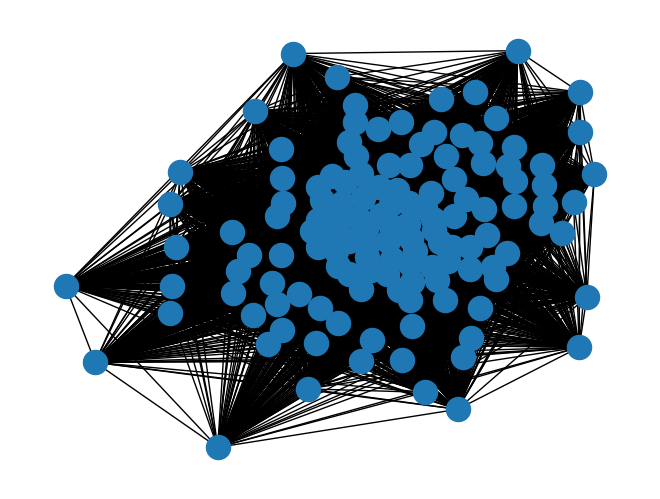

In [21]:
# Graph of feast shared among sources
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G, k = 0.5, iterations=50)
nx.draw(G, pos) #, with_labels = True)
'''
The order in which the nodes are considered can affect the final output. 
In the algorithm the ordering happens using a random shuffle.
'''

comms = nx.community.louvain_communities(G, weight='weight') #list of sets
print('number of communities:', len(comms))

In [ ]:
# Sources sharing chants of some feast and how much

def get_matrix_of_sources_sharing_chants_one_feast(feast_id, compare_func):
    source_chants_dict = {}
    used_sources = []
    filt_feast = data_f['feast_id'] == feast_id
    chants_of_feast = data_f[filt_feast]
    for source_id in sources_f['drupal_path']:
        filt_source = chants_of_feast['drupal_path'] == source_id
        source_chants_dict[source_id] = (chants_of_feast[filt_source]['cantus_id']).tolist()
        if (chants_of_feast[filt_source]['cantus_id']).tolist() != []:
            used_sources.append(source_id)

    all_pairs = [(a, b) for idx, a in enumerate(sources_f['drupal_path']) for b in sources_f['drupal_path'].tolist()[idx + 1:]]
    data_matrix = np.zeros([len(sources), len(sources)])
    for s_i, s_j in all_pairs:
        data_matrix[translate_source(s_i), translate_source(s_j)] = compare_func(source_chants_dict[s_i], source_chants_dict[s_j])
    
    return data_matrix, used_sources

131
71
71


c:\Users\annad\Documents\MFFuck\Bakalářka\moje\myvenv\Lib\site-packages\networkx\algorithms\community\quality.py:244: RuntimeWarning: divide by zero encountered in scalar divide
  norm = 1 / deg_sum**2
c:\Users\annad\Documents\MFFuck\Bakalářka\moje\myvenv\Lib\site-packages\networkx\algorithms\community\quality.py:253: RuntimeWarning: invalid value encountered in scalar divide
  return L_c / m - resolution * out_degree_sum * in_degree_sum * norm
c:\Users\annad\Documents\MFFuck\Bakalářka\moje\myvenv\Lib\site-packages\networkx\algorithms\community\quality.py:253: RuntimeWarning: invalid value encountered in scalar multiply
  return L_c / m - resolution * out_degree_sum * in_degree_sum * norm
c:\Users\annad\Documents\MFFuck\Bakalářka\moje\myvenv\Lib\site-packages\networkx\algorithms\community\louvain.py:281: RuntimeWarning: invalid value encountered in scalar divide
  remove_cost = -weights2com[best_com] / m + resolution * (
c:\Users\annad\Documents\MFFuck\Bakalářka\moje\myvenv\Lib\site-pa

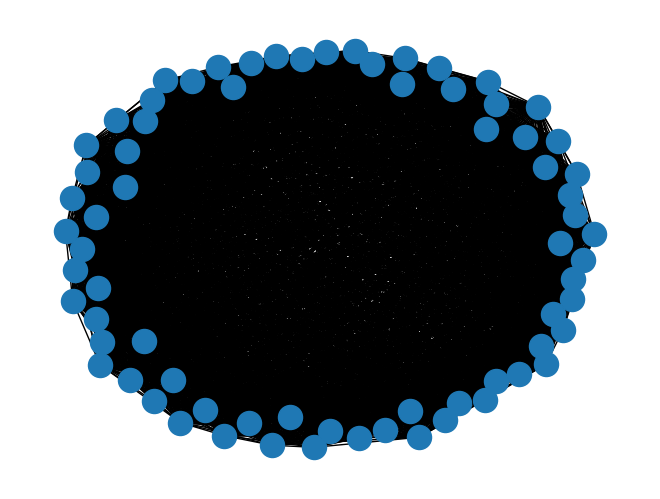

In [ ]:
# Create graph for given feast
# Sivestre 'feast_1531'
# Judith 'feast_0324'
given_feast = ...
source_chant_one_feast_mat, used_sources = get_matrix_of_sources_sharing_chants_one_feast(given_feast, intersection_size)

len_s = len(sources_f)
s1_id_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['drupal_path'].tolist()]))
s2_id_column = len_s * sources_f['drupal_path'].tolist()
s1_tit_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['title'].tolist()]))
s2_tit_column = len_s * sources_f['title'].tolist()
chants_column = []
for i in range(len(s1_id_column)):
    chants_column.append(source_chant_one_feast_mat[translate_source(s1_id_column[i]), translate_source(s2_id_column[i])])

sCh_nodes = used_sources
sCh_edges = [(i, j, {'weight': w}) for i, j, w in zip(s1_id_column, s2_id_column, chants_column) if i != j and (i in used_sources and j in used_sources) and w != 0]


G = nx.Graph()
G.add_nodes_from(sCh_nodes)
G.add_edges_from(sCh_edges)
#nx.draw(G)
community_on_ids = nx.community.louvain_communities(G, weight='weight') #list of sets

print(len(used_sources))
print(len(community_on_ids))



In [ ]:
# Create graph for given feast on titels with title labels

# Sivestre 'feast_1531'
# Judith 'feast_0324'
# feast_1794 vit

given_feast = 'feast_1531'
source_chant_one_feast_mat, used_sources = get_matrix_of_sources_sharing_chants_one_feast(given_feast, Jaccard_metrics)

len_s = len(sources_f)
s1_id_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['drupal_path'].tolist()]))
s2_id_column = len_s * sources_f['drupal_path'].tolist()
s1_tit_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['title'].tolist()]))
s2_tit_column = len_s * sources_f['title'].tolist()
chants_column = []

s1_chants = ...
s2_chants = ...
for i in range(len(s1_id_column)):
    chants_column.append(source_chant_one_feast_mat[translate_source(s1_id_column[i]), translate_source(s2_id_column[i])])

# translate ids to titles
sCh_nodes = []
for node in used_sources:
    node = sources_f[sources_f['drupal_path'] == node]['title'].iloc[0]
    sCh_nodes.append(node)
used_sources = sCh_nodes

sCh_edges = [(i, j, {'weight': w}) for i, j, w in zip(s1_tit_column, s2_tit_column, chants_column) if i != j and (i in used_sources and j in used_sources) and w != 0]


G = nx.Graph()
G.add_nodes_from(sCh_nodes)
G.add_edges_from(sCh_edges)
pos = nx.spring_layout(G, k = 0.6, iterations=50)
nx.draw(G, pos=pos, with_labels = True, font_size = 8)

communit_titles = nx.community.louvain_communities(G, weight='weight') #list of sets

print(len(used_sources))
print(len(communit_titles))

In [ ]:
# Visulize all communities on one geo map with lines
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, rgb2hex

map_centre = [47.466667, 11.166667] # Centre of returned maps

def get_map_with_sources(communities: list, feast_id : str, edges: list):
    """
    Returns folium map with marked provenances of sources that was given in list of communities
    In popups: 
    """

    map = folium.Map(map_centre, zoom_start=5, height='70%', width='70%') #, tiles='Stamen Toner')
    #folium.TileLayer('stamentoner', attr='stamentoner').add_to(map)

    # layer clustering points
    cluster = MarkerCluster().add_to(map) 
    colours = []

    # Colours of communities
    # colormap and normalization of its scale
    cmap = plt.get_cmap('plasma')
    offset = TwoSlopeNorm(vmin = 0, vmax = len(communities), vcenter= (len(communities) / 2))
    for b in range(len(communities)):
        scale = offset(b)
        colour=rgb2hex(cmap(scale))
        colours.append(colour)
    
    # Points
    i = 0
    for community in communities:
        for source in community: # source -> drupal_path
            source_complete = geo_source[geo_source['drupal_path'] == source]
            if len(source_complete) != 0:
                info = "<h4>" + str(source_complete['provenance'].iloc[0]) + "</h4>" + "<h5> rism: " \
                        + str(source_complete['rism'].iloc[0]) + "</h5> <h5> title: "+ source_complete['title'].iloc[0] \
                        #+ "</h5>" #<a href=  \"{}\"  target=\"_blank\" rel=\"noopener noreferrer\"> {} </a>".format(source_complete['drupal_path'], source_complete['drupal_path'])
                popup = folium.Popup(info, max_width=300, min_widt =300)
                #if source_complete['latitude'] is not None:
                #print(source_complete['drupal_path'], source_complete['latitude'].shape, source_complete['longitude'].shape)
                lat = source_complete['latitude'].iloc[0]
                long = source_complete['longitude'].iloc[0]
                #place point on map (variant cluster.add ... if not in comment above)
                cluster.add_child(folium.CircleMarker(location=[lat , long], fill=True, color = colours[i],fill_opacity=0.4, popup=popup))
        i +=1

    # Lines/edges
    for e in edges:
            source1_compl = geo_source[geo_source['drupal_path'] == e[0]]
            source2_compl = geo_source[geo_source['drupal_path'] == e[1]]
            if len(source1_compl) != 0 and len(source2_compl) != 0:
                end_points = [(source1_compl['latitude'].iloc[0], source1_compl['longitude'].iloc[0]), 
                            (source2_compl['latitude'].iloc[0],source2_compl['longitude'].iloc[0])]
                weight = e[2]['weight']
                popup = folium.Popup(str(weight))
                line = folium.PolyLine(locations=end_points, popup=popup)
                map.add_child(line)
    
    map.save(feast_id + 'Cluster_communities_map.html')